In [2]:
!pip install numpy pandas scipy anndata

In [4]:
%pip install anndata

  Using cached anndata-0.10.7-py3-none-any.whl (122 kB)
  Using cached array_api_compat-1.6-py3-none-any.whl (36 kB)
  Using cached natsort-8.4.0-py3-none-any.whl (38 kB)
Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np
import anndata as ad

class DESeqDataSet:
    def __init__(self, counts, sample_info):
        self.counts = counts
        self.sample_info = sample_info
        self.normalizedCounts = None
        self.sizeFactors = None
        self.meanVarZero = None
        self.designMatrix = None

    def get_counts(self):
        return self.counts

    def get_sample_info(self):
        return self.sample_info
    
    def to_anndata(self):
        # Create an AnnData object
        adata = ad.AnnData(X=self.counts.values, obs=self.sample_info, var=pd.DataFrame(index=self.counts.columns))
        return adata

In [11]:
# Importing the classes and functions defined above
# In a real package, you would use: from IDEA.dataset import DESeqDataSet

# Create sample data
counts = pd.DataFrame({
    'gene1': [10, 15, 20],
    'gene2': [5, 8, 12],
    'gene3': [30, 45, 50]
}, index=['sample1', 'sample2', 'sample3'])

sample_info = pd.DataFrame({
    'condition': ['A', 'B', 'A']
}, index=['sample1', 'sample2', 'sample3'])

# Initialize DESeqDataSet
dds = DESeqDataSet(counts, sample_info)

# Test the methods
print("Counts:\n", dds.get_counts())
print("Sample Info:\n", dds.get_sample_info())

# Convert to AnnData
adata = dds.to_anndata()
print("AnnData object:\n", adata)


Counts:
          gene1  gene2  gene3
sample1     10      5     30
sample2     15      8     45
sample3     20     12     50
Sample Info:
         condition
sample1         A
sample2         B
sample3         A
AnnData object:
 AnnData object with n_obs × n_vars = 3 × 3
    obs: 'condition'


In [3]:
def median_of_ratios(adata):
    # Calculate the geometric mean of each gene across all samples
    geometric_means = np.exp(np.log(adata.X + 1).mean(axis=0))
    
    # Compute ratios for each gene in each sample to the geometric mean
    ratios = adata.X / geometric_means
    
    # Median of ratios for each sample
    size_factors = np.median(ratios, axis=1)
    
    return size_factors

def size_factors(adata):
    adata.obs['size_factors'] = median_of_ratios(adata)
    return adata.obs['size_factors']

def normalize_counts(adata):
    if 'size_factors' not in adata.obs:
        size_factors(adata)
    
    # Normalize counts
    adata.layers['normalized'] = adata.X / adata.obs['size_factors'].values[:, np.newaxis]
    return adata

# Sample data
counts = pd.DataFrame({
    'gene1': [10, 15, 20],
    'gene2': [5, 8, 12],
    'gene3': [30, 45, 50]
}, index=['sample1', 'sample2', 'sample3'])

sample_info = pd.DataFrame({
    'condition': ['A', 'B', 'A']
}, index=['sample1', 'sample2', 'sample3'])

# Convert to AnnData
adata = ad.AnnData(X=counts.values, obs=sample_info, var=pd.DataFrame(index=counts.columns))

# Normalize counts
size_factors(adata)
normalize_counts(adata)

# Print results
print("Size Factors:\n", adata.obs['size_factors'])
print("Normalized Counts:\n", adata.layers['normalized'])


Size Factors:
 sample1    0.646779
sample2    0.970169
sample3    1.293558
Name: size_factors, dtype: float64
Normalized Counts:
 [[15.46122811  7.73061405 46.38368432]
 [15.46122811  8.24598832 46.38368432]
 [15.46122811  9.27673686 38.65307026]]


In [4]:
# Normalize counts
size_factors(adata)
normalize_counts(adata)

# Print results
print("Size Factors:\n", adata.obs['size_factors'])
print("Normalized Counts:\n", adata.layers['normalized'])

Size Factors:
 sample1    0.646779
sample2    0.970169
sample3    1.293558
Name: size_factors, dtype: float64
Normalized Counts:
 [[15.46122811  7.73061405 46.38368432]
 [15.46122811  8.24598832 46.38368432]
 [15.46122811  9.27673686 38.65307026]]


In [5]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def estimate_dispersions(dds):
    """
    Estimate the dispersions for each gene.
    
    Parameters:
    dds (anndata.AnnData): AnnData object containing the counts matrix and necessary metadata.

    Returns:
    pd.Series: Pandas Series of dispersions with gene identifiers.
    """
    counts = dds.X
    means = counts.mean(axis=0)
    variances = counts.var(axis=0)
    dispersions = variances / means
    dds.var['dispersion'] = dispersions
    return dds.var['dispersion']

def dispersion_trend(mean, a, b):
    """
    Model function for fitting the dispersion trend.
    
    Parameters:
    mean (float): Mean expression level.
    a (float): Coefficient a.
    b (float): Coefficient b.
    
    Returns:
    float: Fitted dispersion value.
    """
    return a / mean + b

def fit_dispersion_trend(dds):
    """
    Fit the dispersion trend across genes.
    
    Parameters:
    dds (anndata.AnnData): AnnData object containing the counts matrix and necessary metadata.

    Returns:
    np.ndarray: Array of fitted dispersions.
    """
    means = dds.X.mean(axis=0)
    dispersions = dds.var['dispersion'].values
    
    # Filter out zero means to avoid division by zero
    non_zero_means = means[means > 0]
    non_zero_dispersions = dispersions[means > 0]
    
    # Fit the model to the data
    popt, _ = curve_fit(dispersion_trend, non_zero_means, non_zero_dispersions)
    
    # Apply the fitted model to all means
    fitted_dispersions = dispersion_trend(means, *popt)
    dds.var['fitted_dispersion'] = fitted_dispersions
    
    return fitted_dispersions

def shrink_dispersions(dds):
    """
    Shrink the dispersions towards the fitted trend.
    
    Parameters:
    dds (anndata.AnnData): AnnData object containing the counts matrix and necessary metadata.

    Returns:
    pd.Series: Pandas Series of shrunken dispersions with gene identifiers.
    """
    raw_dispersions = dds.var['dispersion']
    fitted_dispersions = dds.var['fitted_dispersion']
    
    # Shrinkage formula: weighted average of raw and fitted dispersions
    shrunken_dispersions = 1 / (1 / raw_dispersions + 1 / fitted_dispersions)
    dds.var['shrunken_dispersion'] = shrunken_dispersions
    
    return dds.var['shrunken_dispersion']


In [6]:
# Estimate dispersions
estimate_dispersions(adata)

# Fit dispersion trend
fit_dispersion_trend(adata)

# Shrink dispersions
shrink_dispersions(adata)

# Print results
print("Raw Dispersions:\n", adata.var['dispersion'])
print("Fitted Dispersions:\n", adata.var['fitted_dispersion'])
print("Shrunken Dispersions:\n", adata.var['shrunken_dispersion'])

Raw Dispersions:
 gene1    1.111111
gene2    0.986667
gene3    1.733333
Name: dispersion, dtype: float64
Fitted Dispersions:
 gene1    1.303898
gene2    0.900984
gene3    1.626230
Name: fitted_dispersion, dtype: float64
Shrunken Dispersions:
 gene1    0.599905
gene2    0.470940
gene3    0.839037
Name: shrunken_dispersion, dtype: float64


In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import rankdata

class DESeqResults:
    def __init__(self, dds, contrast):
        self.dds = dds
        self.contrast = contrast
        self.results = None
    
    def get_results(self):
        return self.results
    
def deseq(dds, contrast):
    """
    Perform differential expression analysis.

    Parameters:
    dds (anndata.AnnData): AnnData object containing the counts matrix and necessary metadata.
    contrast (tuple): A tuple specifying the contrast for differential expression (e.g., ('condition', 'A', 'B')).

    Returns:
    DESeqResults: Object containing the results of the differential expression analysis.
    """
    # Extract counts and metadata
    counts = dds.layers['normalized']
    phenotype_data = dds.obs
    genes = dds.var.index
    condition = contrast[0]
    level1 = contrast[1]
    level2 = contrast[2]

    # Debugging output to ensure correct levels in phenotype data
    print("Phenotype data:")
    print(phenotype_data[condition])
    print(f"Expected levels: {level1}, {level2}")

    # Create design matrix
    design_matrix = pd.get_dummies(phenotype_data[condition], drop_first=False)
    print("Design matrix:")
    print(design_matrix.head())

    # Check if contrast levels are present in design matrix
    if level1 not in design_matrix.columns or level2 not in design_matrix.columns:
        raise ValueError(f"Contrast levels {level1} and {level2} not found in phenotype data.")

    # Recode contrast levels to 0 and 1 for analysis
    design_matrix = design_matrix[[level1, level2]].astype(int)
    design_matrix.columns = [level1, level2]
    print("Recoded design matrix:")
    print(design_matrix.head())

    # Fit the model for each gene
    results = []
    for i, gene in enumerate(genes):
        y = counts[:, i]
        model = sm.OLS(y, design_matrix).fit()
        summary = model.summary2().tables[1]
        log2_fold_change = summary.loc[level2, 'Coef.']
        p_value = summary.loc[level2, 'P>|t|']
        results.append({
            'gene': gene,
            'log2_fold_change': log2_fold_change,
            'p_value': p_value
        })

    results_df = pd.DataFrame(results)
    results_df['padj'] = adjust_pvalues(results_df['p_value'])

    # Create DESeqResults object
    deseq_results = DESeqResults(dds, contrast)
    deseq_results.results = results_df

    return deseq_results

def adjust_pvalues(pvalues):
    """
    Adjust p-values using the Benjamini-Hochberg method.

    Parameters:
    pvalues (pd.Series): Series of p-values.

    Returns:
    pd.Series: Series of adjusted p-values.
    """
    pvalues_sorted = np.sort(pvalues)
    pvalues_order = np.argsort(pvalues)
    n = len(pvalues)
    adjusted_pvalues = np.zeros(n)
    cumulative_min = np.inf
    for i in range(n-1, -1, -1):
        pval = pvalues_sorted[i]
        cumulative_min = min(cumulative_min, pval * n / (i + 1))
        adjusted_pvalues[pvalues_order[i]] = cumulative_min
    return adjusted_pvalues


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plotVolcano(res):
    # Create a volcano plot
    plt.figure(figsize=(10, 8))
    res['-log10(p_value)'] = -np.log10(res['p_value'])
    significant = (res['p_value'] < 0.05) & (abs(res['log2_fold_change']) > 1)
    
    plt.scatter(res[~significant]['log2_fold_change'], res[~significant]['-log10(p_value)'], color='gray', alpha=0.5)
    plt.scatter(res[significant]['log2_fold_change'], res[significant]['-log10(p_value)'], color='red', alpha=0.8)
    
    plt.axhline(y=-np.log10(0.05), color='blue', linestyle='--', linewidth=0.8)
    plt.axvline(x=1, color='blue', linestyle='--', linewidth=0.8)
    plt.axvline(x=-1, color='blue', linestyle='--', linewidth=0.8)
    
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-Log10(p-value)')
    plt.title('Volcano Plot')
    plt.show()

def plotHeatmap(res, adata, top_n=10):
    # Select top N differentially expressed genes based on p-value
    top_genes = res.nsmallest(top_n, 'p_value')['gene']
    counts = pd.DataFrame(adata.layers['normalized'], index=adata.obs.index, columns=adata.var.index)
    top_counts = counts[top_genes]

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(top_counts.T, cmap='viridis', xticklabels=adata.obs['condition'], yticklabels=top_genes)
    plt.title(f'Top {top_n} Differentially Expressed Genes')
    plt.xlabel('Samples')
    plt.ylabel('Genes')
    plt.show()


Estimating size factors...
Normalizing counts...
Estimating dispersions...
Fitting dispersion trend...
Shrinking dispersions...
Performing differential expression analysis...
Phenotype data:
sample1    A
sample2    B
sample3    A
Name: condition, dtype: object
Expected levels: A, B
Design matrix:
         A  B
sample1  1  0
sample2  0  1
sample3  1  0
Recoded design matrix:
         A  B
sample1  1  0
sample2  0  1
sample3  1  0
Differential expression analysis results:
    gene  log2_fold_change       p_value          padj
0  gene1         15.461228  3.103149e-16  9.309446e-16
1  gene2          8.245988  8.391525e-02  8.391525e-02
2  gene3         46.383684  7.468188e-02  8.391525e-02
Plotting Volcano plot...


/Users/gayathridonepudi/anaconda3/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gayathridonepudi/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/gayathridonepudi/anaconda3/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gayathridonepudi/anaconda3/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


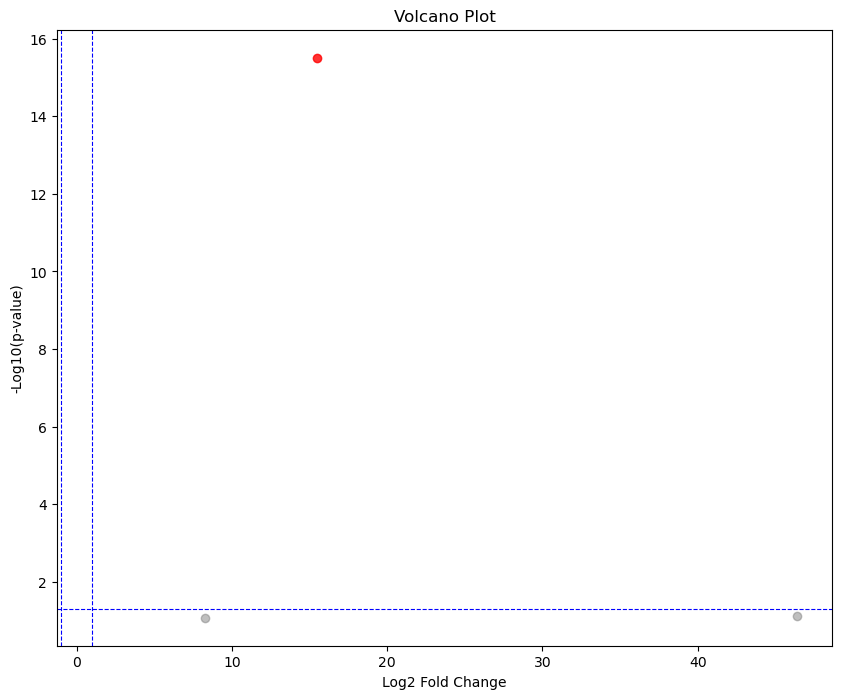

Plotting heatmap...


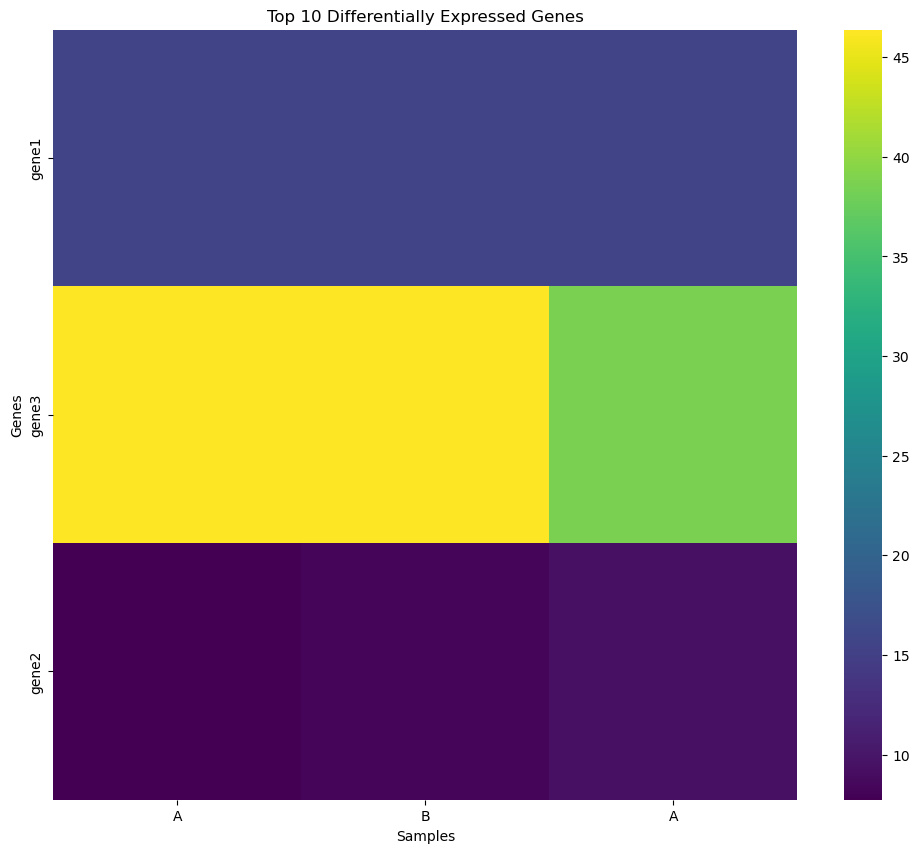

In [21]:
# import pandas as pd
# import anndata as ad
# from dataset import DESeqDataSet
# from normalization import size_factors, normalize_counts
# from dispersion import estimate_dispersions, dispersion_trend, fit_dispersion_trend, shrink_dispersions
# from differential_expression import deseq
# from utilities import plotVolcano, plotHeatmap

# Sample data for testing
def create_sample_data():
    counts = pd.DataFrame({
        'gene1': [10, 15, 20],
        'gene2': [5, 8, 12],
        'gene3': [30, 45, 50]
    }, index=['sample1', 'sample2', 'sample3'])

    sample_info = pd.DataFrame({
        'condition': ['A', 'B', 'A']
    }, index=['sample1', 'sample2', 'sample3'])

    # Convert to AnnData
    adata = ad.AnnData(X=counts.values, obs=sample_info, var=pd.DataFrame(index=counts.columns))
    return adata

# Main test workflow
def test_workflow():
    adata = create_sample_data()

    # Perform normalization
    print("Estimating size factors...")
    size_factors(adata)
    print("Normalizing counts...")
    normalize_counts(adata)

    # Estimate dispersions
    print("Estimating dispersions...")
    estimate_dispersions(adata)
    print("Fitting dispersion trend...")
    fit_dispersion_trend(adata)
    print("Shrinking dispersions...")
    shrink_dispersions(adata)

    # Perform differential expression analysis
    contrast = ('condition', 'A', 'B')
    print("Performing differential expression analysis...")
    results = deseq(adata, contrast)

    # Print results
    print("Differential expression analysis results:")
    df_results = results.get_results()
    print(df_results)

    print("Plotting Volcano plot...")
    plotVolcano(df_results)

    print("Plotting heatmap...")
    plotHeatmap(df_results, adata)
    
if __name__ == "__main__":
    test_workflow()